## **Import Libraries**

In [2]:
%%capture


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.model_selection import train_test_split ,KFold
from sklearn.feature_selection import SelectKBest, f_regression ,RFE
from sklearn.linear_model import LinearRegression,LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


from xgboost import XGBRegressor
sns.set(style="darkgrid")

## **Read Data**

In [4]:
df_train = pd.read_csv('./Dataset/train.csv')
df_test = pd.read_csv('./Dataset/test.csv')

In [5]:
df_train.columns

Index(['id', 'squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')

In [6]:
df_train.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22730 entries, 0 to 22729
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 22730 non-null  int64  
 1   squareMeters       22730 non-null  int64  
 2   numberOfRooms      22730 non-null  int64  
 3   hasYard            22730 non-null  int64  
 4   hasPool            22730 non-null  int64  
 5   floors             22730 non-null  int64  
 6   cityCode           22730 non-null  int64  
 7   cityPartRange      22730 non-null  int64  
 8   numPrevOwners      22730 non-null  int64  
 9   made               22730 non-null  int64  
 10  isNewBuilt         22730 non-null  int64  
 11  hasStormProtector  22730 non-null  int64  
 12  basement           22730 non-null  int64  
 13  attic              22730 non-null  int64  
 14  garage             22730 non-null  int64  
 15  hasStorageRoom     22730 non-null  int64  
 16  hasGuestRoom       227

In [8]:
df_train.isna().sum()

id                   0
squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

**No Missing values**

## **Summary Statistics for continous features**

In [9]:
continous_feat = df_train.columns[df_train.nunique()  > 20]
df_train[continous_feat].describe().T

,count,mean,std,min,25%,50%,75%,max
id,22730.0,1.136450e+04,6.561730e+03,0.0,5682.25,11364.5,17046.75,22729.0
squareMeters,22730.0,4.658622e+04,4.952124e+04,89.0,20392.75,44484.0,71547.00,6071330.0
numberOfRooms,22730.0,4.824109e+01,2.822643e+01,1.0,25.00,47.0,75.00,100.0
floors,22730.0,4.730598e+01,4.777721e+01,1.0,25.00,45.0,69.00,6000.0
cityCode,22730.0,5.001380e+04,3.000664e+04,3.0,22936.00,50414.0,76291.00,491100.0
made,22730.0,2.008005e+03,1.188268e+02,1990.0,2000.00,2006.0,2014.00,10000.0
basement,22730.0,5.283647e+03,3.047084e+03,4.0,2977.25,5359.0,7746.00,91992.0
attic,22730.0,5.067982e+03,3.097348e+03,1.0,2599.00,4977.0,7652.00,96381.0
garage,22730.0,5.304696e+02,2.748406e+02,4.0,297.00,515.0,767.00,9017.0
price,22730.0,4.634457e+06,2.925163e+06,10313.5,2041739.10,4450823.4,7159919.50,10004278.3


## **Summary Statistics for Binary categorical features**

In [10]:
cat_col = df_train.columns[(df_train.nunique()  < 10)]
df_train[cat_col].describe().T

,count,mean,std,min,25%,50%,75%,max
hasYard,22730.0,0.475891,0.499429,0.0,0.0,0.0,1.0,1.0
hasPool,22730.0,0.452750,0.497773,0.0,0.0,0.0,1.0,1.0
isNewBuilt,22730.0,0.467972,0.498984,0.0,0.0,0.0,1.0,1.0
hasStormProtector,22730.0,0.460009,0.498409,0.0,0.0,0.0,1.0,1.0
hasStorageRoom,22730.0,0.461681,0.498540,0.0,0.0,0.0,1.0,1.0


## **EDA**

## **Correlation Matrix**

<AxesSubplot:>

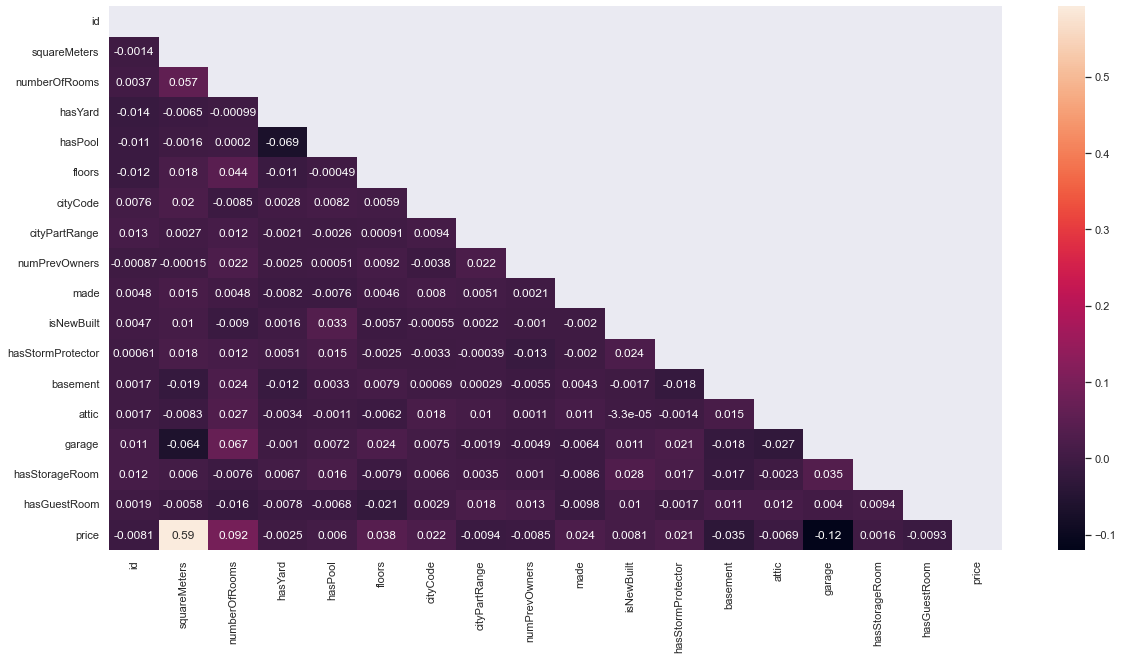

In [11]:
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(df_train.corr()))
sns.heatmap(df_train.corr(),annot=True,mask=mask)

*  target `price` is highly correlated with  independent `squareMeters` feature

#### **Value Counts for  Binary categorical features**

In [12]:
cols_to_check = df_train.columns[df_train.nunique() < 10]

# print value counts of each selected column
for col in cols_to_check:
    print(f"Feature Name : {col} \n")
    print(df_train[col].value_counts())
    print("")
    print("="*20)

Feature Name : hasYard 

0    11913
1    10817
Name: hasYard, dtype: int64

Feature Name : hasPool 

0    12439
1    10291
Name: hasPool, dtype: int64

Feature Name : isNewBuilt 

0    12093
1    10637
Name: isNewBuilt, dtype: int64

Feature Name : hasStormProtector 

0    12274
1    10456
Name: hasStormProtector, dtype: int64

Feature Name : hasStorageRoom 

0    12236
1    10494
Name: hasStorageRoom, dtype: int64



## **Dealing With Outliers**


In [13]:
df_train.made.value_counts().sort_index()

1990       77
1991       30
1992       59
1993      651
1994      628
1995      631
1996      822
1997      592
1998      719
1999      588
2000     3588
2001       59
2002        1
2003     1156
2004      915
2005      764
2006      921
2007     1021
2008      981
2009      972
2010      152
2011       68
2012       51
2013      934
2014     1070
2015     1036
2016      910
2017      741
2018      927
2019      956
2020      595
2021      110
10000       5
Name: made, dtype: int64

**Year "10000" ? Definitely an Outlier.**

In [14]:
df_train = df_train.query("made != 10_000") #dropping rows made in year 10000 valuesd

## **Box Plot**


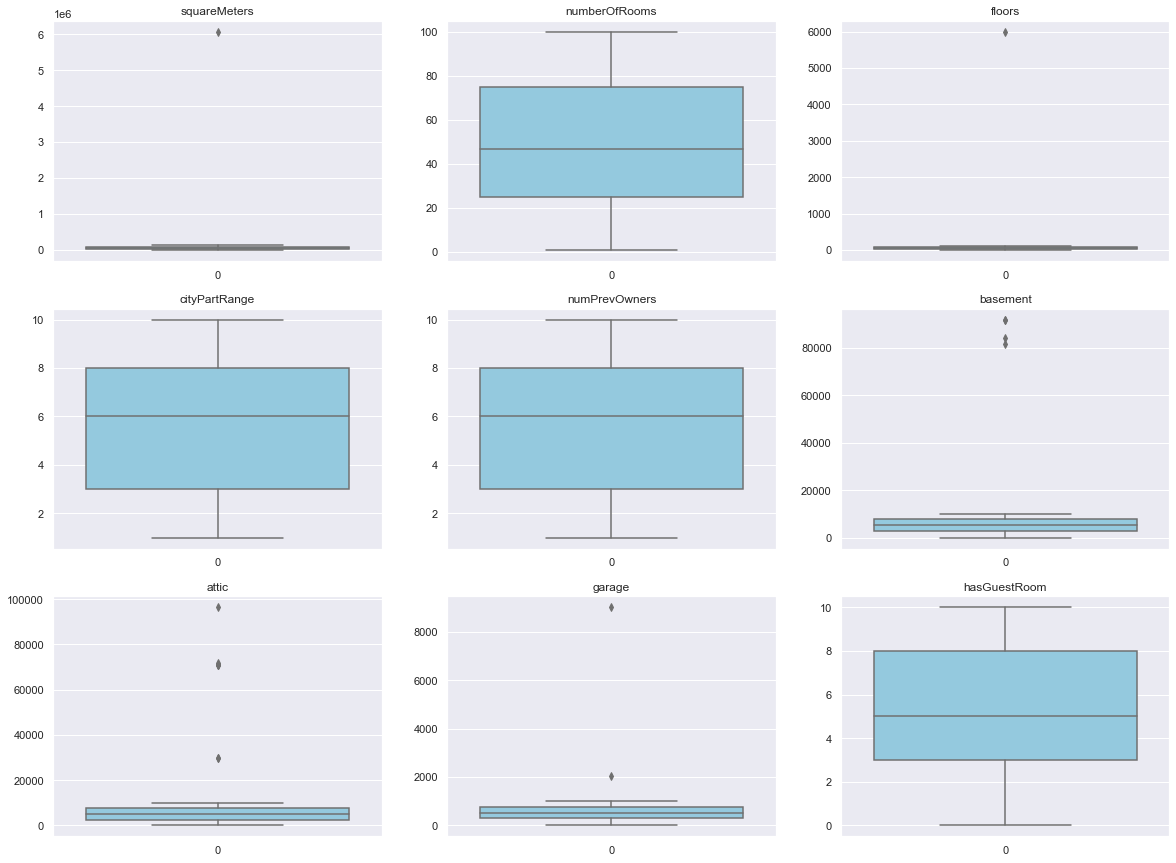

In [15]:
# list of column names
cols = ['squareMeters', 'numberOfRooms','floors','cityPartRange', 'numPrevOwners','basement', 'attic','garage','hasGuestRoom']

sns.set(style="darkgrid")
def plot_boxplots(df, column_names, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,15))
    for i, column in enumerate(column_names):
        row, col = i//ncols, i%ncols
        sns.boxplot(data=df[column], ax=axes[row][col], color='skyblue')
        axes[row][col].set_title(column)

plot_boxplots(df_train, cols, 3, 3)
plt.show()

In [16]:
df_train.shape

(22725, 18)

In [17]:
# dropping rows based on above boxplots
df_train = df_train.query("squareMeters < 1e6")
df_train = df_train.query("floors < 1000")
df_train = df_train.query("basement < 20_000")
df_train = df_train.query("attic < 20_000")
df_train = df_train.query("garage < 1500")

df_train.shape

(22710, 18)

## **Scatter Plot**


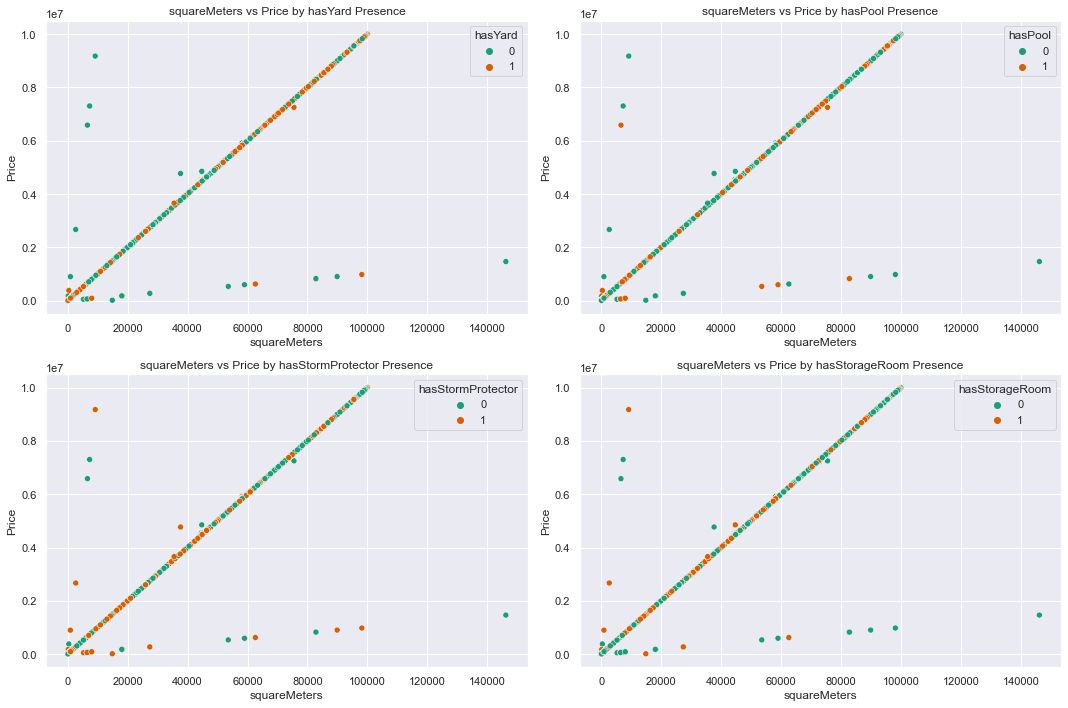

In [18]:
# Create a list of columns to plot
columns = ['hasYard', 'hasPool', 'hasStormProtector', 'hasStorageRoom']

# Create a subplot for each column in the list
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axs = axs.ravel()

for i, column in enumerate(columns):
    sns.scatterplot(x=df_train['squareMeters'], y=df_train['price'], hue=df_train[column], ax=axs[i],palette='Dark2')
    axs[i].set_title('squareMeters vs Price by '+ column +' Presence')
    axs[i].set_xlabel('squareMeters')
    axs[i].set_ylabel('Price')
# Show the subplot
plt.tight_layout()
plt.show()

## **Count Plot**


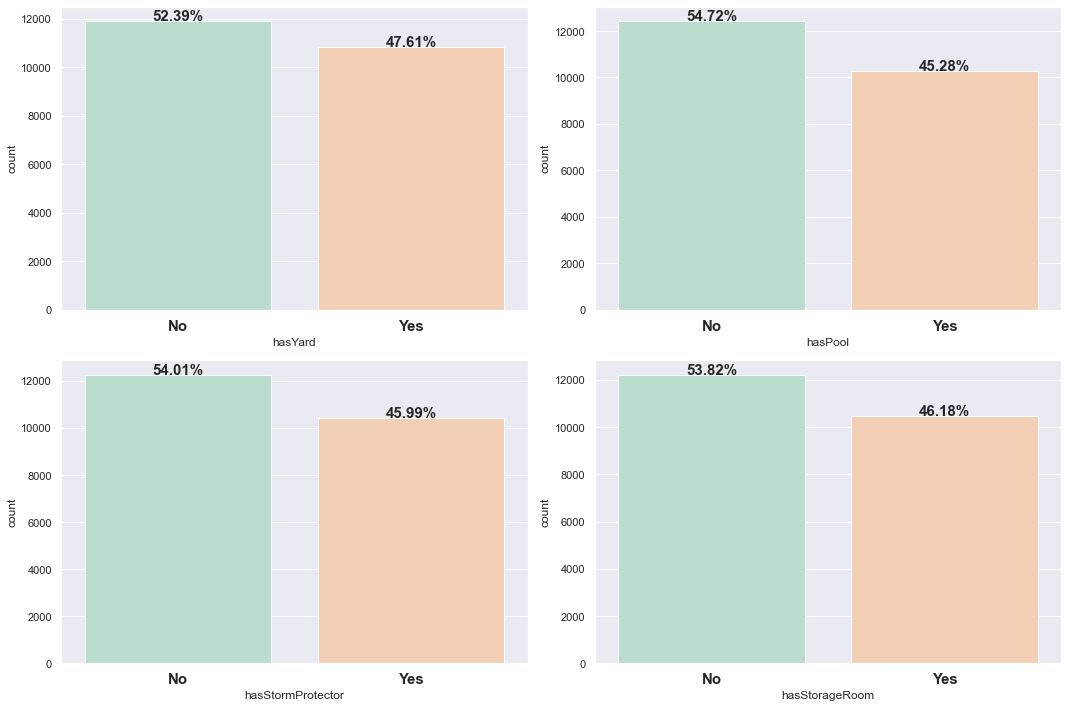

In [19]:
# Create a list of columns to plot
columns = ['hasYard', 'hasPool', 'hasStormProtector', 'hasStorageRoom']

# Create a subplot for each column in the list
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axs = axs.ravel()

for i, column in enumerate(columns):
    sns.countplot(x=df_train[column], ax=axs[i],palette='Pastel2')
    axs[i].set_xticklabels(['No', 'Yes'], fontsize=15, fontweight='bold')
    for j in axs[i].patches:
        height = j.get_height()
        axs[i].text(j.get_x() + j.get_width() / 2.,
                height + 20,
                '{:1.2f}%'.format(height / len(df_train) * 100),
                ha="center", fontsize=15,fontweight='bold')

# Show the subplot
plt.tight_layout()
plt.show()

## **Target Price Distribution**

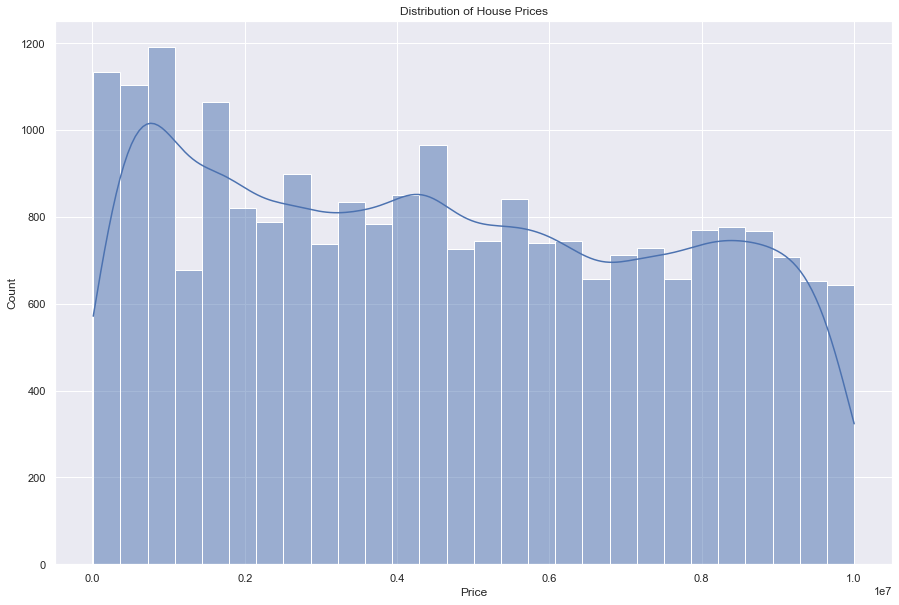

In [20]:

plt.figure(figsize=(15, 10))
# Plot a Seaborn distplot of the "price" column
sns.histplot(df_train['price'], kde=True,palette='Pastel2')

# Add a title and x-axis label
plt.title("Distribution of House Prices")
plt.xlabel("Price")

# Show the plot
plt.show()

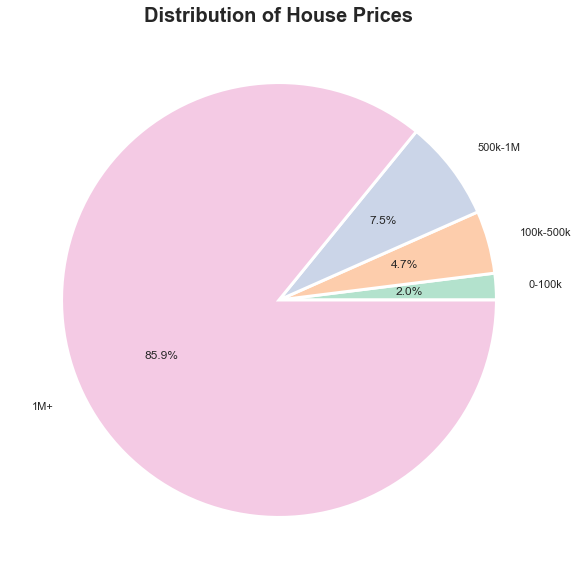

In [21]:

plt.figure(figsize=(15, 10))
bins = [0, 100000, 500000,1000000, df_train['price'].max()]
labels = ['0-100k', '100k-500k','500k-1M', '1M+']
df_train['price_range'] = pd.cut(df_train['price'], bins=bins, labels=labels)



plt.pie(df_train['price_range'].value_counts().sort_values(),autopct='%.1f%%',labels=labels,colors=sns.color_palette('Pastel2'),labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
# Add a title
plt.title("Distribution of House Prices",fontdict={'fontweight':'bold','fontsize':20})

# Show the plot
plt.show()

## **Grouped plots**


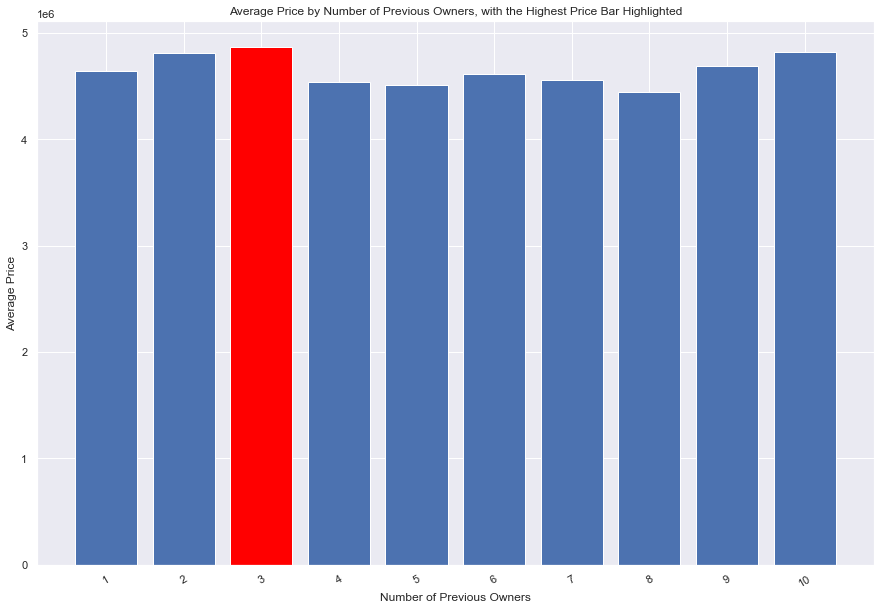

In [22]:
def grouped_plot(column:str,col_title:str):
    """
    group by column name and plot its average price with highest price highlighted as red color
    """
    plt.figure(figsize=(15, 10)) 
    # Group the data by the number of previous owners
    grouped = df_train.groupby(column)[['price']].mean().reset_index()

    # Sort the grouped data by price in descending order
    grouped = grouped.sort_values(by='price',ascending=False)

    # Get the height values for each bar in the plot
    heights = grouped['price'].values

    # Plot the bar chart
    plt.bar(grouped[column], heights)

    # Color only the highest value bar
    highest_index = grouped['price'].idxmax()
    plt.bar(grouped.loc[highest_index, column], grouped.loc[highest_index, 'price'], color='red')

    # Add x-axis and y-axis labels
    plt.xlabel(col_title)
    plt.ylabel("Average Price")
    plt.xticks(grouped[column], rotation=30)
    plt.title("Average Price by "+col_title+", with the Highest Price Bar Highlighted")

    
    
grouped_plot('numPrevOwners','Number of Previous Owners')
# Show the plot
plt.show()

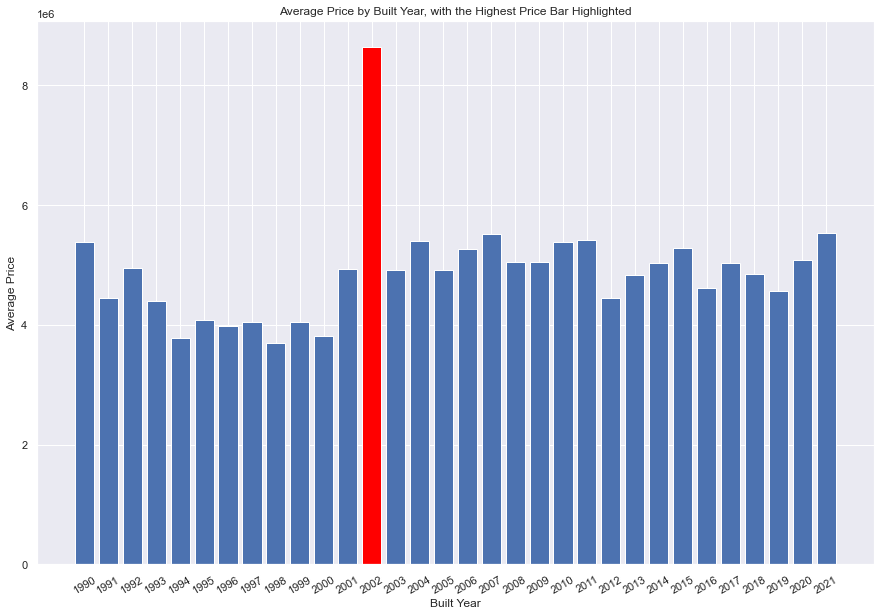

In [23]:
grouped_plot('made','Built Year')

## **Line Chart**


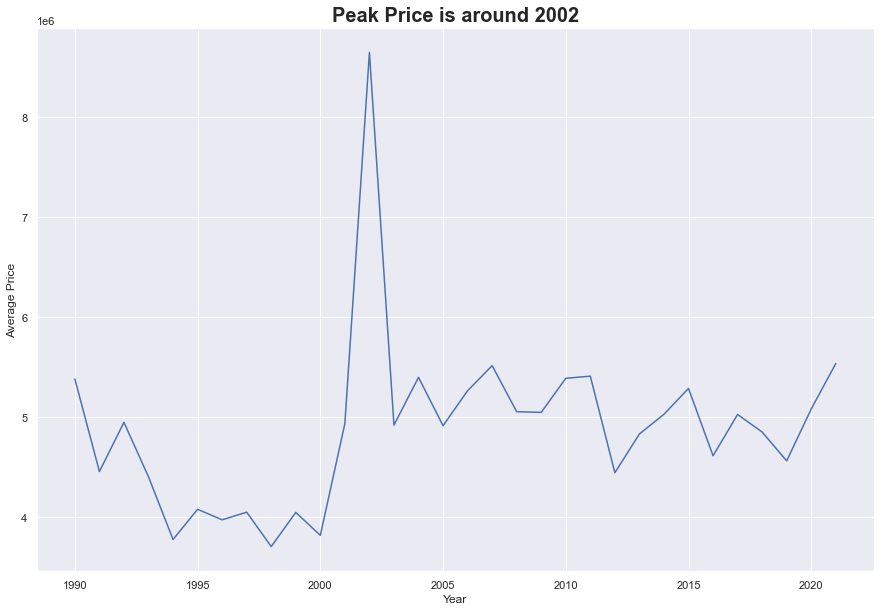

In [24]:
plt.figure(figsize=(15, 10))

# Convert the made column to a datetime year type
df_train['made'] = pd.to_datetime(df_train['made'], format='%Y')
df_train['made'] = df_train['made'].dt.year

# Group the data by year
grouped = df_train.groupby('made')[['price']].mean().reset_index()

# Plot the line chart
plt.plot(grouped['made'], grouped['price'])

# Add x-axis and y-axis labels
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.title("Peak Price is around 2002",fontdict={'fontweight':'bold','fontsize':20})
# Show the plot
plt.show()

## **Feature Engineering**

**Some Feature construction/interaction ideas**

* Interaction between square footage and number of rooms: This can give an indication of how the space is being used in the house.

* Interaction between city code (zip code) and city part range: This can give an indication of how the location affects the price.
* Interaction between the number of rooms and the presence of a yard: This can give an indication of how outdoor space affects the price.

* Interaction between the year the property was made and whether it's a new built: This can give an indication of how newness affects the price.
* Interaction between the size of the basement and the size of the attic: This can give an indication of how much additional space is available in the house.
* Interaction between the number of previous owners and the presence of a pool: This can give an indication of how much previous owners value outdoor amenities.
* Interaction between the presence of a storage room and the presence of a guest room: This can give an indication of how much space is dedicated to storage and guests.
* Interaction between the size of the garage and the number of floors in the house: This can give an indication of how much space is dedicated to parking.
* Interaction between the presence of a storm protector and the number of previous owners: This can give an indication of how much previous owners value safety features.
* Extract information from dates : extract information such as the age of the house and the time elapsed since the house was built.

In [25]:
def feature_interaction(df):

    df['squareMeters_numRooms'] = df['squareMeters'] * df['numberOfRooms']
    df['zip_part_interaction'] = df['cityCode'] * df['cityPartRange']
    df['room_yard_interaction'] = df['numberOfRooms'] * df['hasYard']
    df['made_isNewBuilt'] = df['made'] * df['isNewBuilt']
    df['Basement_Attic_Interaction'] = df['basement'] * df['attic']
    df['numPrevOwners_hasPool'] = df['numPrevOwners'] * df['hasPool']
    df['storage_guest_interaction'] = df['hasStorageRoom'] * df['hasGuestRoom']
    df['garage_floors_interaction'] = df['garage'] * df['floors']
    df['storm_prevOwners'] = df['hasStormProtector'] * df['numPrevOwners']
    # assuming the data upto 2021 and current year is 2021 for simplicity
    df['age'] = 2021 - df['made']
    
    return df

df_train = feature_interaction(df_train)
df_test = feature_interaction(df_test)

interaction_cols = ['squareMeters_numRooms','zip_part_interaction','room_yard_interaction','made_isNewBuilt',
                    'Basement_Attic_Interaction','numPrevOwners_hasPool','storage_guest_interaction','garage_floors_interaction','storm_prevOwners','age','price']
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(df_train[interaction_cols].corr()))
sns.heatmap(df_train[interaction_cols].corr(),annot=True,mask=mask)


* `squareMeters_numRooms` is highly correlated with our target `price` column

## **Baseline XGBoost**

* In this baseline model we will consider all the features availabe in the dataset along with features we have constructed.

In [27]:
X = df_train.drop(['price','id','price_range'],axis=1)
y= df_train['price']

print("features shape :" ,X.shape)
print("target shape :",y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape :{X_train.shape} ,y_train shape :{y_train.shape}")
print(f"X_test shape :{X_train.shape} ,y_test shape :{y_train.shape}")

features shape : (22710, 26)
target shape : (22710,)
X_train shape :(18168, 26) ,y_train shape :(18168,)
X_test shape :(18168, 26) ,y_test shape :(18168,)


In [28]:
# Train the XGB model

def xgb_train(X_train,X_test):
    model_params = {
    'objective': 'reg:squarederror',
    'boosting_type': 'gbtree',
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 3,
#     'min_child_weight': 1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
    'verbosity': 0,
    'early_stopping_rounds':100
    }
    xgb_model = XGBRegressor(**model_params)
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)],verbose=0)

    # Predict on the validation set
    y_pred = xgb_model.predict(X_test)

    # Evaluate the model using mean squared error
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error: ", rmse)
    return xgb_model

xgb_model = xgb_train(X_train,X_test)

Root Mean Squared Error:  155537.2726773427


### Submitting baseline predictions

In [32]:
baseline_test_pred = xgb_model.predict(df_test)

submission = pd.read_csv('./kaggle_submissions/sample_submission.csv')

submission['price'] = baseline_test_pred

submission.to_csv('baseline-xgb-allfeatures.csv', index=False)
submission.head()

,id,price
0,22730,4755061.50
1,22731,6164972.00
2,22732,9073590.00
3,22733,1635195.75
4,22734,6758811.00


 ## **Feature selection techniques** : To identify the most important features
 
1.  **Univariate Feature Selection**: This technique selects the best features based on univariate statistical tests between each feature and the target variable.
2. **Recursive Feature Elimination**: This technique starts with all the features, trains the model and eliminates the least important feature
3. **Lasso Regularization**: This technique uses Lasso regularization to shrink the coefficients of less important features towards zero. Features with a coefficient of zero are then removed.
4. **Random Forest Feature Importance**: This technique uses the feature importance attribute from the Random Forest model to select the best features.

* Once we select the best features using the above techniques , We will train XGboost model on the training data and ensemble ( average) the predictions obtained using the above 4 techniques.

## **Univariate Feature Selection**

In [33]:

selector_kbest = SelectKBest(f_regression, k=5)
X_kbest_train = selector_kbest.fit_transform(X_train, y_train)
X_kbest_test = selector_kbest.transform(X_test)

cols = X.columns

mask = selector_kbest.get_support()

selected_cols = cols[mask]

X_new = X[selected_cols]
print(X_new.columns)

#selectKbest model
xgb_kbest = xgb_train(X_kbest_train,X_kbest_test)


Index(['squareMeters', 'made', 'garage', 'squareMeters_numRooms', 'age'], dtype='object')
Root Mean Squared Error:  163027.46241175575


In [34]:
final_kbest_pred = xgb_kbest.predict(df_test[selected_cols])

## **Recursive Feature Elimination**

In [35]:
# select 25 features
selector_rfe = RFE(LinearRegression(), n_features_to_select=25)
#fit transform
X_rfe_train = selector_rfe.fit_transform(X_train, y_train)
X_rfe_test = selector_rfe.transform(X_test)

selected_features_RFE = X.columns[selector_rfe.get_support()]
print("Selected Features:", selected_features_RFE)

#rfe_model
xgb_rfe = xgb_train(X_rfe_train,X_rfe_test)

Selected Features: Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'squareMeters_numRooms', 'zip_part_interaction',
       'room_yard_interaction', 'made_isNewBuilt', 'numPrevOwners_hasPool',
       'storage_guest_interaction', 'garage_floors_interaction',
       'storm_prevOwners', 'age'],
      dtype='object')
Root Mean Squared Error:  155172.1301621711


In [36]:
final_rfe_pred = xgb_rfe.predict(df_test[selected_features_RFE])
# submission['price'] = final_rfe_pred

# submission.to_csv('rfe-lgbm-selected.csv', index=False)

## **Lasso Regularization**

In [37]:
selector_lassocv = LassoCV()
selector_lassocv.fit(X_train, y_train)
mask = selector_lassocv.coef_ != 0

# Get the column names of the selected features
selected_features_lasso = X.columns[mask]

X_lassocv_train = X_train.loc[:,mask]
X_lassocv_test = X_test.loc[:,mask]
print("Selected Features:", selected_features_lasso)

#lasso_cv model
xgb_lassocv = xgb_train(X_lassocv_train,X_lassocv_test)

Selected Features: Index(['squareMeters', 'squareMeters_numRooms', 'Basement_Attic_Interaction'], dtype='object')
Root Mean Squared Error:  171616.70105451535


In [38]:
final_lassocv_pred = xgb_lassocv.predict(df_test[selected_features_lasso])

## **Random Forest Feature Importance**

In [39]:
# initialize the selector
selector_rf = RandomForestRegressor()

# fit the selector to the data
selector_rf.fit(X_train, y_train)

# get the feature importances
imp = selector_rf.feature_importances_

# keep only the features with importance greater than 0.01

X_rf_train = X_train.loc[:,imp > 0.01]
X_rf_test = X_test.loc[:,imp > 0.01]

# get the column names of the selected features
selected_features_RF = X_rf_test.columns

print("Selected Features:", selected_features_RF)

# rf model
xgb_rf = xgb_train(X_rf_train,X_rf_test)

Selected Features: Index(['squareMeters'], dtype='object')
Root Mean Squared Error:  171906.94101176356


In [40]:
final_rf_pred = xgb_rf.predict(df_test[selected_features_RF])

## **Ensemble predictions**

In [41]:
# averaging all the feature selection + lgbm predictions 
ensembled_pred = (final_rf_pred + final_lassocv_pred + final_kbest_pred + final_rfe_pred) / 4 

submission['price'] = ensembled_pred

submission.to_csv('ensembled-xgb-selected.csv', index=False)